In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"


In [1]:
!pip install segmentation-models-pytorch
!pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=193d975d10603466962bbf5299dc6dd7d96c8f571b14357527ef93a3af1c8111
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2065bbb95d8bf80d27426f7d1368c42e6f27fe02f4898220de59bedea67f5140
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
ERROR: Could not find a version that satisfies the requ

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import pandas as pd 
from tqdm import tqdm
import sys
import glob
import cv2

import pydicom
from sklearn.utils import shuffle

import albumentations as A

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import  ReduceLROnPlateau

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!pip install "catalyst==20.08.1"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 10.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
import numpy as np
from catalyst import utils
import cv2
import glob
from PIL import Image
import os.path as osp
from tqdm import tqdm
from typing import Callable, List, Tuple
import torch
import catalyst
import wandb

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

In [ ]:
def example(image_path = '/kaggle/input/12tabajteselifeer/train/Images/frame1000_aug1.jpg', 
             mask_path ='/kaggle/input/12tabajteselifeer/train/Labels/frame1000_aug1.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)    
    plt.figure(figsize=(18, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
example()

We’ll need helper functions for label image conversion from 3 channel RGB color image to 1 channel label index image

In [6]:
class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self):
        clr_tab = {}
       
        clr_tab['road'] = [0, 0, 0]
        clr_tab['car'] = [250, 250, 55]
        clr_tab['lane'] = [177, 177, 177]
        clr_tab['background'] = [255, 255, 255]
       
        return clr_tab

    def colorTable(self):
        return self.clr_tab
   
    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

In [7]:
clrEnc = UAVidColorTransformer()

def prepareTrainIDForDir(gtDirPath, saveDirPath):
    lbl_dir = osp.join(gtDirPath, 'Labels')
    lbl_paths = [p for p in os.listdir(lbl_dir) if p.endswith('.png') or p.endswith('.jpg')]

    # Create output directory
    trainId_dir = osp.join(saveDirPath, 'TrainId')
    if not osp.isdir(trainId_dir):
        os.makedirs(trainId_dir)
        assert osp.isdir(trainId_dir), f'Fail to create directory: {trainId_dir}'

    for lbl_p in tqdm(lbl_paths, desc="Processing labels"):
        lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
        trainId_path = osp.join(trainId_dir, lbl_p)

        gt = np.array(Image.open(lbl_path))
        trainId = clrEnc.transform(gt, dtype=np.uint8)
        Image.fromarray(trainId).save(trainId_path)

If we use joblib.Parallel, we can speedup ~3x

In [8]:
prepareTrainIDForDir('/kaggle/input/arkotobokamikorbi/train', './trainlabels/')
prepareTrainIDForDir('/kaggle/input/arkotobokamikorbi/valid', './validlabels/')

Processing labels: 100%|██████████| 64/64 [00:03<00:00, 19.59it/s]


After creating label images, we’ll define lists of images and labels for our Dataset.

In [9]:
train_image_list = sorted(glob.glob(pathname='/kaggle/input/arkotobokamikorbi/train/Images/*.jpg', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/TrainId/*.png', recursive=True))
valid_image_list = sorted(glob.glob(pathname='/kaggle/input/arkotobokamikorbi/valid/Images/*.jpg', recursive=True))
valid_mask_list =  sorted(glob.glob(pathname='./validlabels/TrainId/*.png', recursive=True))
print(train_image_list[0])
print(train_mask_list[0])

/kaggle/input/arkotobokamikorbi/train/Images/12th_2306_copy1.jpg
./trainlabels/TrainId/12th_2306_copy1.png


# Dataset

Set seed and mix precision training.

In [10]:
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)
is_fp16_used = True

In our Dataset, we can read images, extract values of classes from segmentation mask, apply augmentation and pre-processing transformations.

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):

    CLASSES = [ 'road', 'car', 'lane','background']
    
    def __init__(
            self, 
            images_list, 
            masks_list, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes
        
        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255
        
        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask

    def __len__(self):
        return len(self.images_list)

Helper functions for visualization.

In [12]:
def visualize(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")
        
    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")
        
def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")
        
        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")
        
def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

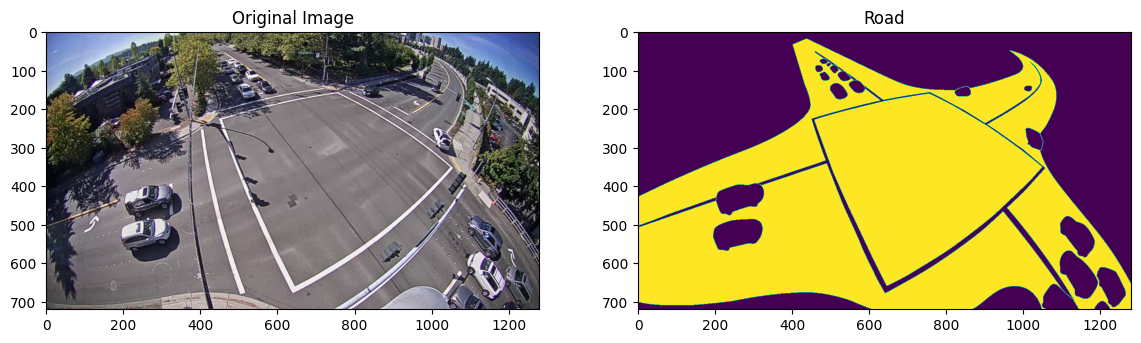

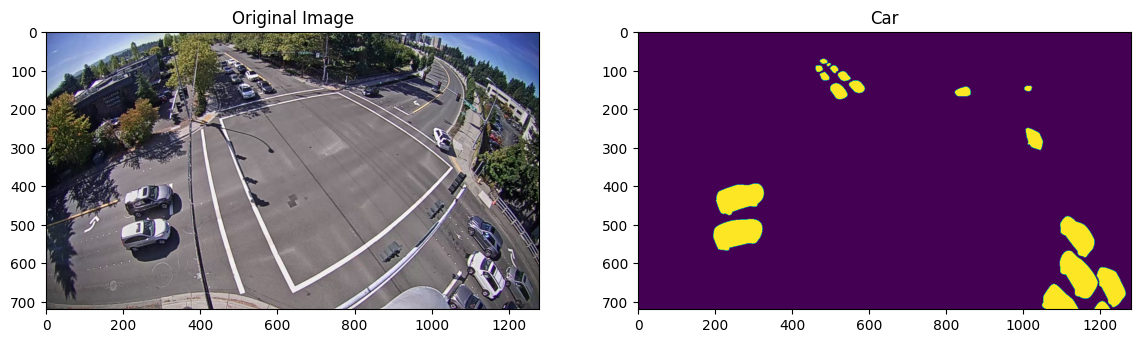

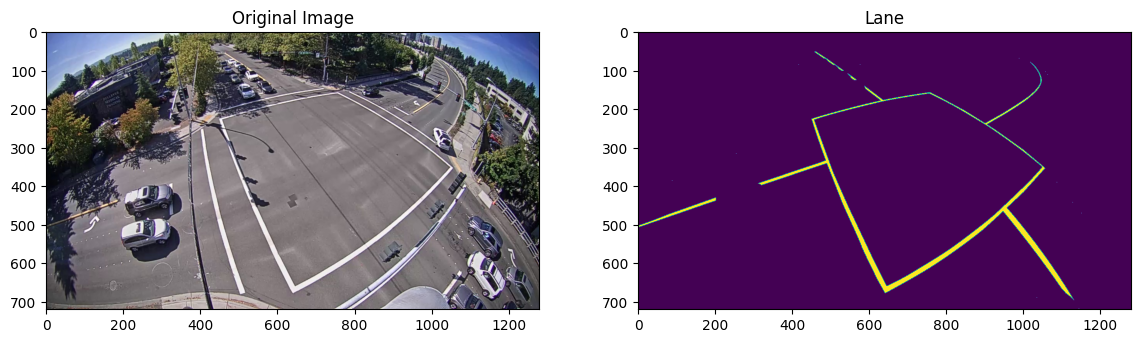

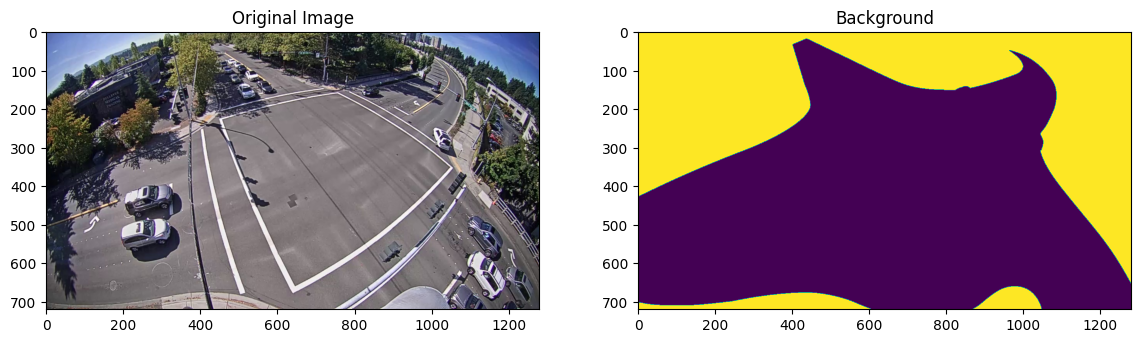

In [13]:
labels =  [ 'road', 'car', 'lane','background']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])
    image, mask = dataset[4]
    visualize(image=image, mask=mask.squeeze(), label=label)


Visualizing segmentation masks for all classes.

We'll resize images to `576*1024` to keep 9:16 ratio. 

Augmentation list:
* *HorizontalFlip*
* *OneOf(RandomBrightnessContrast, CLAHE, HueSaturationValue)*
* *IAAAdditiveGaussianNoise* with 0.2 probability

*Note:* For better result we could crop each image into 16 evenly distributed smaller(1280*720) overlapped images that cover the whole image for training.

In [ ]:
!pip install -U albumentations



In [17]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.3),
        
        albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.7),
        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.2, contrast_limit=0.2, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        #albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.GaussNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [15]:
import albumentations as albu
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [14]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
         # Resize images and masks
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.3),
        albu.Rotate(limit=19, p=0.5),  # ✅ Fix: Keeps dimensions consistent

        albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=19, p=0.7),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.2, contrast_limit=0.2, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),


        albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),

         albu.GaussNoise(p=0.2),

        
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [ ]:
pip show albumentations


Visualizing augmented images and masks.

In [18]:
labels =  [ 'road', 'car','lane', 'background']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list, 
        train_mask_list, 
        augmentation=get_training_augmentation(), 
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[8]
    visualize(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

TypeError: Dataset() takes no arguments

In [15]:
import segmentation_models_pytorch as smp




# create segmentation model with pretrained encoder
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES =  [ 'road', 'car','lane', 'background']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 242MB/s] 


In [26]:

import segmentation_models_pytorch as smp

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['road', 'car', 'lane', 'background']
ACTIVATION = 'softmax2d'  # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable multi-GPU if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)

# Move model to device
model = model.to(DEVICE)

# Get preprocessing function
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
 print(f"Using {torch.cuda.device_count()} GPUs!")

In [ ]:
print("Train images:", len(train_image_list))
print("Valid images:", len(valid_image_list))


We’ll define Dataloaders and set batch size to 6, because of memory limitation.

In [16]:
batch_size = 6
train_dataset = Dataset(
    train_image_list, 
    train_mask_list, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valid_image_list, 
    valid_mask_list, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [54]:
!pip install segmentation-models-pytorch-losses


ERROR: Could not find a version that satisfies the requirement segmentation-models-pytorch-losses (from versions: none)
ERROR: No matching distribution found for segmentation-models-pytorch-losses


In [17]:
import segmentation_models_pytorch.utils

import segmentation_models_pytorch as smp
TRAINING = True

# Set num of epochs
EPOCHS = 130

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

#import smp.losses as smp_losses
#loss = smp_losses.DiceLoss() + smp_losses.FocalLoss() + smp_losses.JaccardLoss()


# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00004),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2 , eta_min=5e-5,
)

In [19]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [20]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, dice_loss - 0.4608, iou_score - 0.5908]
Model saved!

Epoch: 1
valid: 100%|██████████| 11/11 [00:06<00:00,  1.73it/s, dice_loss - 0.3182, iou_score - 0.8365]
Model saved!

Epoch: 2
valid: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s, dice_loss - 0.2835, iou_score - 0.8756]
Model saved!

Epoch: 3
valid: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s, dice_loss - 0.2532, iou_score - 0.896]
Model saved!

Epoch: 4
valid: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s, dice_loss - 0.2268, iou_score - 0.9061]
Model saved!

Epoch: 5
valid: 100%|██████████| 11/11 [00:06<00:00,  1.70it/s, dice_loss - 0.2054, iou_score - 0.9122]
Model saved!

Epoch: 6
valid: 100%|██████████| 11/11 [00:06<00:00,  1.70it/s, dice_loss - 0.1887, iou_score - 0.921] 
Model saved!

Epoch: 7
valid: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s, dice_loss - 0.1747, iou_score - 0.9245]
Model saved!

Epoch: 8
valid: 100%|██████████| 11/11 [00:06<00:00,  1.

KeyboardInterrupt: 

Selecting optimization level: **01** - Mixed Precision (recommended for typical use)

In [ ]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")

In [ ]:
fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(cfg.BATCH_SIZE):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(img.permute(1,2, 0))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

In [ ]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

In [ ]:
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

In [ ]:
class CONFIG:
    # use the 16 bit floating point arithmetic (should speeds up training/inference)
    USE_MIXED_PRECISION = "fp16"    # other values possible, "fp16" or None

    # set to true to read the dataset from kaggle, false when doing locally
    USE_KAGGLE = True

    # downscaling the images : to make the inference on kaggle faster and keep within reason on GPU there, 
    #                          I set it to 2 (so the image is scaled from (256,256) to (128, 128)), None 
    #                          keeps the original shape 
    DOWNSCALE = 2

    # Imagenet channelwise mean
    MEAN = [0.485, 0.456, 0.406]

    # imagenet, channelwise standard deviation
    STD = [0.229, 0.224, 0.225]

    # epsilon for DICE, IoU losses (now 1e-6, however in some papers set to 1)
    EXTRA_LOSS_EPS = 1e-6

    # style of plots, I find darkgrid nice for regular plots
    SNS_STYLE = "darkgrid"

    BATCH_SIZE = 8

    SINGLE_NETWORK_TRAINING_EPOCHS = 15

    CE_VS_DICE_EVAL_EPOCHS = 15

    DELTA_BETA = 0.2

cfg = CONFIG()    

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Load your trained model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
best_model = torch.load("/kaggle/working/best_model.pth", map_location=DEVICE)  # Load model
best_model.eval()

# Load a single test image
image_path = "/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images/000100.png"
image = cv2.imread(image_path)  # Load image
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
new_height = (image.shape[0] // 32) * 32
new_width = (image.shape[1] // 32) * 32
image = cv2.resize(image, (new_width, new_height))

# Preprocess: Resize, Normalize, Convert to Tensor
 transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])
    
image_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

# Perform Inference
with torch.no_grad():
    pred_mask = best_model(image_tensor)  # Get prediction
    
    #pred_mask = pred_mask.squeeze(0)  # Remove batch dimension
    #pred_mask = torch.argmax(pred_mask, dim=0).cpu().numpy()
    # Get class indices
    pred_mask = pred_mask.permute(1, 2, 0)
    pred_mask = torch.argmax(pred_mask, dim=2)

# Display Results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(pred_mask, cmap="magma")
ax[1].set_title("Predicted Mask")
ax[1].axis("off")

plt.show()


In [ ]:
if is_fp16_used:
    fp16_params = dict(opt_level="O1")
else:
    fp16_params = None

print(f"FP16 params: {fp16_params}")

Experiment settings:
* Loss: BCEDiceLoss with 0.5 contibution of BCE and Dice
* Optimizer: Lookahead(improves the learning stability and lowers the variance of its inner optimizer)
* Scheduler: OneCycleLRWithWarmup with 2 warmup steps
* Initial learning rate is set to 1e-3, and 1e-4 on encoder. Number of epochs to 30.

In [ ]:
import collections
import sys

if sys.version_info >= (3, 10):
    collections.MutableMapping = collections.abc.MutableMapping

In [ ]:
from catalyst.contrib.nn import BCEDiceLoss, RAdam, Lookahead, OneCycleLRWithWarmup
from catalyst.dl import SupervisedRunner

logdir = "./logs"
num_epochs = 30
learning_rate = 1e-3
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': learning_rate}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])
optimizer = Lookahead(base_optimizer)
criterion = BCEDiceLoss(activation=None)
runner = SupervisedRunner()
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.0016, 0.0000001),
    init_lr = learning_rate,
    warmup_steps=2
)



Importing callbacks for metrics and logging

In [ ]:
from catalyst.dl.callbacks import IouCallback, WandbLogger, EarlyStoppingCallback, ClasswiseIouCallback

callbacks = [
    IouCallback(activation = 'none'),
    ClasswiseIouCallback(classes=CLASSES, activation = 'none'),
    EarlyStoppingCallback(patience=7, metric='iou', minimize=False),
    WandbLogger(project='Project_Name', name='Run_Name'),
    
]

In [ ]:
TRAINING = True
learning_rate = 1e-3
num_epochs = 40

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import pandas as pd 
from tqdm import tqdm
import sys
import glob
import cv2

import pydicom
from sklearn.utils import shuffle

import albumentations as A

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import  ReduceLROnPlateau

In [ ]:
from segmentation_models_pytorch import utils, metrics, losses
import torch
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS=40
# Model & Optimizer
model.to(DEVICE)
learning_rate = 1e-3

base_optimizer = Adam([
    {'params': model.decoder.parameters(), 'lr': learning_rate}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])

optimizer = base_optimizer  

# Learning Rate Scheduler
steps_per_epoch = len(train_loader)  # Get steps per epoch
total_steps = EPOCHS * steps_per_epoch  # Total optimizer steps

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.0016,
    total_steps=total_steps,
    pct_start=0.1,
)

# Metrics & Loss
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
loss = smp.utils.losses.DiceLoss()

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

# Training Loop
TRAINING = True
best_iou_score = 0.0

if TRAINING:
    for epoch in range(EPOCHS):

        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training step
        train_logs = train_epoch.run(train_loader)

        # Update LR scheduler
        scheduler.step()

        # Validation step
        valid_logs = valid_epoch.run(valid_loader)

        # Save model if IoU improves
        current_iou_score = valid_logs["iou_score"]
        if current_iou_score > best_iou_score:
            best_iou_score = current_iou_score
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            print(f"✅ Model saved (IoU: {best_iou_score:.4f})")


In [ ]:
import segmentation_models_pytorch as smp
import torch
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam
from torch.utils.data import DataLoader
from segmentation_models_pytorch.losses import DiceLoss



# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 40

# Model & Optimizer
model.to(DEVICE)
learning_rate = 1e-3

base_optimizer = Adam([
    {'params': model.decoder.parameters(), 'lr': learning_rate}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
])

optimizer = base_optimizer  

# Learning Rate Scheduler
steps_per_epoch = len(train_loader)  # Get steps per epoch
total_steps = EPOCHS * steps_per_epoch  # Total optimizer steps

scheduler = OneCycleLR(
    optimizer,
    max_lr=0.0016,
    total_steps=total_steps,
    pct_start=0.1,
)

# Metrics & Loss
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
loss = smp.utils.losses.DiceLoss()

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss,
    optimizer=optimizer,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)


# Training Loop
TRAINING = True
best_iou_score = 0.0

if TRAINING:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        # Training step
        train_logs = train_epoch.run(train_loader)

        # Update LR scheduler
        scheduler.step()

        # Validation step
        valid_logs = valid_epoch.run(valid_loader)

        # Save model if IoU improves
        current_iou_score = valid_logs["iou_score"]
        if current_iou_score > best_iou_score:
            best_iou_score = current_iou_score
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            print(f"✅ Model saved (IoU: {best_iou_score:.4f})")


Model training, set main_metric to **'iou'**

In [ ]:
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

In [ ]:
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
batch = next(iter(loaders['valid']))
dataset = Dataset(valid_image_list, valid_mask_list, augmentation=get_validation_augmentation())
image, _ = dataset[0]
truth_path='../input/uavid-semantic-segmentation-dataset/valid/valid/seq16/Labels/000000.png'

In [ ]:
from catalyst.utils import mask_to_overlay_image

pred = mask_to_overlay_image(image=image, masks=single[0], threshold=0.4)
visualize_overlay(image, pred, truth_path=truth_path)

In [ ]:
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/*/TrainId/*.png', recursive=True))

In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

# UAVid Color Transformer (Same as your given class)
class UAVidColorTransformer:
    def __init__(self):
        self.clr_tab = self.createColorTable()
        self.id_tab = {k: self.clr2id(v) for k, v in self.clr_tab.items()}

    def createColorTable(self):
        return {
            
            'Road': [128, 64, 128],
            'Static_Car': [192, 0, 192],
            
            'Moving_Car': [64, 0, 128]
        }

    def clr2id(self, clr):
        return clr[0] + clr[1] * 255 + clr[2] * 255 * 255

    def inverse_transform(self, label):
        label_img = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid, val in enumerate(values):
            mask = (label == tid)
            label_img[mask] = val
        return label_img

# Initialize the transformer
clrEnc = UAVidColorTransformer()

# Load trained model
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'softmax'  # Since multi-class, softmax is better

model = smp.FPN(encoder_name=ENCODER, encoder_weights=None, classes=3, activation=ACTIVATION)
#model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu")))  # Load trained model
# Load only the weights to avoid security risks
state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True)

# Apply the weights to the model
model.load_state_dict(state_dict)

model.eval()  # Set to evaluation mode

# Function to preprocess an input image
def preprocess_image(image_path, input_size=(256, 256)):  
    image = Image.open(image_path).convert("RGB")  
    image = image.resize(input_size)  
    image = np.array(image) / 255.0  # Normalize
    image = np.transpose(image, (2, 0, 1))  # Change to (C, H, W)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict segmentation
def predict_segmentation(image_path, output_path):
    # Load and preprocess the image
    input_tensor = preprocess_image(image_path)
    
    # Run inference
    with torch.no_grad():
        output = model(input_tensor)
    
    # Convert output to label map
    predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Convert the predicted mask to a color image (if needed)
# Assuming you have a color transformer like UAVidColorTransformer
    predicted_color_mask = clrEnc.inverse_transform(predicted_mask)

    
    # Save and show the result
    segmented_img = Image.fromarray( predicted_color_mask )
    segmented_img.save(output_path)
    
    plt.imshow(segmented_img)
    plt.axis("off")
    plt.title("Predicted Segmentation")
    plt.show()

# Example usage
predict_segmentation("/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png", "segmented_output.png")


In [ ]:
image_path = "/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png"
image = io.read_image(image_path)
print(image.shape)
show_image(image)

In [ ]:
from torchvision import transforms as T

In [ ]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

#preprocess_input = get_preprocessing_fn('refficientnet-b3', pretrained='imagenet')

In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

# UAVid Color Transformer (Same as your given class)


# Load trained model
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'softmax'  # Since multi-class, softmax is better

model = smp.FPN(encoder_name=ENCODER, encoder_weights=None, classes=3, activation=ACTIVATION)
#model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu")))  # Load trained model
# Load only the weights to avoid security risks
state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True)

# Apply the weights to the model
model.load_state_dict(state_dict)

model.eval()  # Set to evaluation mode

# Function to preprocess an input image
image = Image.open('/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png')
image = np.array(image)
normalized_image = preprocessing(image=image)["image"]
input_tensor = torch.as_tensor(normalized_image)
input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0)  # HWC -> BCHW
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output_mask = model(input_tensor)

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.shape[:2], mode="bilinear", align_corners=False
)
mask = mask[0].argmax(0).cpu().numpy()

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.axis("off")
plt.imshow(image)
plt.title("Input Image")

plt.subplot(122)
plt.axis("off")
plt.imshow(mask)
plt.title("Output Mask")

plt.show()





In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the preprocessing function using segmentation_models_pytorch
def preprocessing(image, encoder_name='efficientnet-b3', encoder_weights='imagenet'):
    # Get preprocessing function for the specified encoder
    preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, encoder_weights)
    
    # Convert image to numpy array if it's a PIL image
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Apply preprocessing
    normalized_image = preprocessing_fn(image)
    
    # Convert to tensor and permute dimensions
    input_tensor = torch.as_tensor(normalized_image).permute(2, 0, 1).unsqueeze(0)  # HWC -> BCHW
    return input_tensor

# Load trained model
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'  # Since multi-class, softmax is better

model = smp.FPN(encoder_name=ENCODER, encoder_weights=None, classes=3, activation=ACTIVATION)

# Load only the weights to avoid security risks
state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode

# Load and preprocess the image
image = Image.open('/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png')
input_tensor = preprocessing(image, encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)

# Move tensor to the appropriate device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output_mask = model(input_tensor)

# Postprocess mask
mask = torch.nn.functional.interpolate(
    output_mask, size=image.size[::-1], mode="bilinear", align_corners=False
)
mask = mask[0].argmax(0).cpu().numpy()

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.axis("off")
plt.imshow(image)
plt.title("Input Image")

plt.subplot(122)
plt.axis("off")
plt.imshow(mask)
plt.title("Output Mask")

plt.show()

In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# ===========================
# 1. Load Trained Model
# ===========================
ENCODER = 'efficientnet-b3'
ACTIVATION = 'softmax'  # Multi-class segmentation

#model = smp.FPN(encoder_name=ENCODER, encoder_weights='imagenet', classes=3, activation=ACTIVATION)
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights="imagenet", 
    classes=3,  # Ensure this matches your trained model
    activation=ACTIVATION
)

# Load trained weights
state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True)

# Apply the weights to the model
model.load_state_dict(state_dict)

model.eval() 

# ===========================
# 2. Load & Preprocess Test Image
# ===========================
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, "imagenet")

def preprocess_image(image_path, target_size=(256, 256)):  
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel input
    
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.tensor(preprocessing_fn(x.permute(1, 2, 0).numpy())).permute(2, 0, 1))  # ✅ Fix
    ])
    
    image = transform(image)
    return image.unsqueeze(0) # Add batch dimension


# Replace with your test image path
test_image_path = "/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png"
image_tensor = preprocess_image(test_image_path)

# ===========================
# 3. Run Inference
# ===========================
with torch.no_grad():  
    output = model(image_tensor)  # Model prediction
    predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # Get class labels per pixel

# ===========================
# 4. Convert Mask to RGB
# ===========================
def decode_segmentation_mask(mask, class_colors):
    """Convert class indices to RGB image using color mapping."""
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id, color in class_colors.items():
        color_mask[mask == class_id] = color
    
    return color_mask

# Define class colors (Change according to your dataset)
CLASS_COLORS = {
    0:(128, 64, 128),
    1: (128, 64, 128),       # Background - Black
    2: (192, 0, 192),     # Class 1 - Red
        # Class 2 - Green
}

color_mask = decode_segmentation_mask(predicted_mask, CLASS_COLORS)

# ===========================
# 5. Visualize Results
# ===========================
original_image = Image.open(test_image_path).convert("RGB")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(color_mask)
plt.title("Predicted Segmentation Mask")

plt.show()


In [ ]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
axes[0].imshow(image)

axes[0].set_title("Input Image")

# Predicted Mask
axes[1].imshow(predicted_mask)
axes[1].axis("off")
axes[1].set_title("Predicted Mask")

In [ ]:
predicted_mask = model.predict(image)
axes[i,2].imshow(predicted_mask)
axes[i,2].title.set_text('Predicted Mask')

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import segmentation_models_pytorch as smp
from torchvision.transforms import functional as F

# Initialize the UAVidColorTransformer
clrEnc = UAVidColorTransformer()

# Load the trained model
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'  # Since multi-class, softmax is better

#model = smp.FPN(encoder_name=ENCODER, encoder_weights=None, classes=3, activation=ACTIVATION)  # Adjust classes if needed
model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu")))
model.eval()  # Set to evaluation mode

# Define preprocessing function
def preprocess_image(image_path, size=(512, 512)):
    """
    Preprocess the image for the model.
    - Resize the image.
    - Normalize the image (if required by the model).
    - Convert to tensor.
    """
    image = Image.open(image_path).convert('RGB')
    image = image.resize(size, Image.BILINEAR)  # Resize to model input size
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = F.to_tensor(image).unsqueeze(0)  # Convert to tensor and add batch dimension
    return image

# Define prediction function
def predict_mask(model, image_tensor):
    """
    Predict the mask for a given image tensor.
    """
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Get class IDs
    return output

# Define function to save color-coded mask
def save_color_mask(mask, output_path):
    """
    Convert predicted mask to color-coded mask and save it.
    """
    color_mask = clrEnc.inverse_transform(mask)  # Convert class IDs to color mask
    Image.fromarray(color_mask).save(output_path)

# Process test images
test_image_dir = '/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images'
output_mask_dir = '/kaggle/working/'

if not os.path.exists(output_mask_dir):
    os.makedirs(output_mask_dir)

for image_name in os.listdir(test_image_dir):
    image_path = os.path.join(test_image_dir, image_name)
    output_path = os.path.join(output_mask_dir, image_name)

    # Preprocess the image
    image_tensor = preprocess_image(image_path)

    # Predict the mask
    predicted_mask = predict_mask(model, image_tensor)

    # Save the color-coded mask
    save_color_mask(predicted_mask, output_path)

    print(f"Processed {image_name}")

In [ ]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# UAVidColorTransformer for label conversion
class UAVidColorTransformer:
    def __init__(self):
        self.clr_tab = self.createColorTable()
        self.id_tab = {k: self.clr2id(v) for k, v in self.clr_tab.items()}

    def createColorTable(self):
        return {
           
            'Road': [128, 64, 128],
            'Static_Car': [192, 0, 192],
            
            'Moving_Car': [64, 0, 128],
        }
        

    def clr2id(self, clr):
        return clr[0] + clr[1] * 255 + clr[2] * 255 * 255

    def transform(self, label, dtype=np.int32):
        height, width = label.shape[:2]
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:, :, 0] + id_label[:, :, 1] * 255 + id_label[:, :, 2] * 255 * 255
        for tid, val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

    def inverse_transform(self, label):
        label_img = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid, val in enumerate(values):
            mask = (label == tid)
            label_img[mask] = val
        return label_img

# Preprocess input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))  # Resize if necessary
    image = np.array(image) / 255.0  # Normalize to [0,1]
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Convert to (1, C, H, W)
    return image

# Predict segmentation mask
def predict_mask(image_path, model):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)  # Forward pass

    output = torch.sigmoid(output, dim=1)  # Get class probabilities
    mask = output.squeeze(0).cpu().numpy()  # Shape: (num_classes, H, W)
    return mask

# Convert predicted mask to RGB image
def visualize_mask(mask, color_transformer):
    class_map = np.argmax(mask, axis=0)  # Convert probabilities to class indices
    color_mask = color_transformer.inverse_transform(class_map)  # Convert to RGB
    return Image.fromarray(color_mask)

# Load trained model
ENCODER = 'efficientnet-b3'
ACTIVATION = 'sigmoid'
ENCODER_WEIGHTS = 'imagenet'
model = smp.FPN(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=3, activation=ACTIVATION)

state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"))
model.load_state_dict(state_dict)
model.eval()

# Predict and visualize
test_image_path = "/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images/000000.png"
predicted_mask = predict_mask(test_image_path, model)

clrEnc = UAVidColorTransformer()
segmented_image = visualize_mask(predicted_mask, clrEnc)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(test_image_path))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Predicted Segmentation Mask")

plt.show()


In [ ]:
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

# Assuming UAVidColorTransformer is already defined as in your code
clrEnc = UAVidColorTransformer()

# Load the trained model
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax'

model = smp.FPN(encoder_name=ENCODER, encoder_weights=None, classes=3, activation=ACTIVATION)  # Adjust classes if necessary

# Load the model with `weights_only=True` for security
state_dict = torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(state_dict)

model.eval()

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load and preprocess the test image
test_image_path = '/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images/000000.png'
test_image = Image.open(test_image_path).convert('RGB')
test_image_tensor = preprocess(test_image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(test_image_tensor)

# Get the predicted class indices
predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Convert the predicted mask to color labels
predicted_color_mask = clrEnc.inverse_transform(predicted_mask)

# Save or display the predicted mask
predicted_color_mask_image = Image.fromarray(predicted_color_mask)
predicted_color_mask_image.save('predicted_mask.png')
predicted_color_mask_image.show()

In [ ]:
import segmentation_models_pytorch as smp

# Define model parameters
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'  # Use sigmoid for multi-label segmentation
CLASSES = ['road', 'static_car', 'moving_car']

# Create the model
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Print model summary
print(model)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Preprocess the input image
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Adjust size as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load and preprocess the test image
test_image_path = '/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images/000000.png'
test_image = Image.open(test_image_path).convert('RGB')
test_image_tensor = preprocess(test_image).unsqueeze(0)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
    output = model(test_image_tensor)

# Get the predicted class indices
predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
print(predicted_mask)

# Convert the predicted mask to a color image (if needed)
# Assuming you have a color transformer like UAVidColorTransformer
predicted_color_mask = clrEnc.inverse_transform(predicted_mask)

# Save or display the predicted mask
predicted_color_mask_image = Image.fromarray(predicted_color_mask)
predicted_color_mask_image.save('predicted_mask.png')
predicted_color_mask_image.show()

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

# Define the model parameters
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'  # Use 'softmax' if multi-class segmentation
CLASSES = ['road', 'static_car', 'moving_car']

# Load the trained model
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Load the model weights
model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True))
model.eval()  # Set the model to evaluation mode

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load and preprocess the test image
test_image_path = '/kaggle/input/one-image/frame_0002.jpg'  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert('RGB')  # Ensure the image is in RGB format
test_image_tensor = preprocess(test_image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(test_image_tensor)

# Postprocess the output
if ACTIVATION == 'sigmoid':
    # For multi-label segmentation, apply a threshold (e.g., 0.5) to get binary masks
    predicted_mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
elif ACTIVATION == 'softmax':
    # For multi-class segmentation, take the argmax to get the class indices
    predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Ensure the predicted_mask is 2D
if predicted_mask.ndim == 3:
    # If the mask has a channel dimension, reduce it to 2D
    predicted_mask = np.argmax(predicted_mask, axis=0)  # For multi-class segmentation
elif predicted_mask.ndim == 2:
    # Already 2D, no action needed
    pass
else:
    raise ValueError(f"Unexpected mask shape: {predicted_mask.shape}")

# Convert the predicted mask to a color image
predicted_color_mask = inverse_transform(predicted_mask, color_map)

# Convert the predicted mask to a color image (optional)
# Assuming you have a color transformer like UAVidColorTransformer
def inverse_transform(mask, color_map):
    """
    Convert a mask (H, W) with class indices to a color image (H, W, 3).
    color_map: A dictionary mapping class indices to RGB colors.
    """
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for class_idx, color in color_map.items():
        color_mask[mask == class_idx] = color
    return color_mask

# Define a color map for visualization
color_map = {
    
    0: [128, 64, 128],  # Road
    1: [192, 0, 192],   # Static Car
    2: [64, 0, 128], 
   # Moving Car
}

# Convert the predicted mask to a color mask
predicted_color_mask = inverse_transform(predicted_mask, color_map)

# Save or display the predicted mask
predicted_color_mask_image = Image.fromarray(predicted_color_mask)
predicted_color_mask_image.save('predicted_mask.png')  # Save the mask as an image
predicted_color_mask_image.show()  # Display the mask

In [ ]:
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

# Define the model parameters
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'  # Use 'softmax' if multi-class segmentation
CLASSES = ['road', 'static_car', 'moving_car']

# Load the trained model
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Load the model weights
model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu"), weights_only=True))
model.eval()  # Set the model to evaluation mode

# Define the preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Define a function to convert a mask to a color image
def mask_to_color(mask, color_map):
    """
    Convert a mask (H, W) with class indices to a color image (H, W, 3).
    color_map: A dictionary mapping class indices to RGB colors.
    """
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for class_idx, color in color_map.items():
        color_mask[mask == class_idx] = color
    return color_mask

# Define a color map for visualization
color_map = {
    0: [128, 64, 128],  # Road
    1: [192, 0, 192],   # Static Car
    2: [64, 0, 128],    # Moving Car
}

# Paths to your test dataset
test_image_dir = '/kaggle/input/uavid-semantic-segmentation-dataset/test/test/seq21/Images/000000.png'  # Directory containing test images
test_label_dir = 'path_to_test_labels'  # Directory containing ground truth labels
output_dir = 'path_to_save_predictions'  # Directory to save predicted masks

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate over the test images
for image_name in os.listdir(test_image_dir):
    # Load and preprocess the test image
    image_path = os.path.join(test_image_dir, image_name)
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)

    # Postprocess the output
    if ACTIVATION == 'sigmoid':
        # For multi-label segmentation, apply a threshold (e.g., 0.5) to get binary masks
        predicted_mask = (output.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    elif ACTIVATION == 'softmax':
        # For multi-class segmentation, take the argmax to get the class indices
        predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Ensure the predicted_mask is 2D
    if predicted_mask.ndim == 3:
        # If the mask has a channel dimension, reduce it to 2D
        predicted_mask = np.argmax(predicted_mask, axis=0)  # For multi-class segmentation
    elif predicted_mask.ndim == 2:
        # Already 2D, no action needed
        pass
    else:
        raise ValueError(f"Unexpected mask shape: {predicted_mask.shape}")

    # Convert the predicted mask to a color image
    predicted_color_mask = mask_to_color(predicted_mask, color_map)

    # Save the predicted mask
    output_path = os.path.join(output_dir, image_name)
    Image.fromarray(predicted_color_mask).save(output_path)

    print(f"Saved predicted mask for {image_name} to {output_path}")

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Model parameters
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'  # Use 'softmax' for multi-class segmentation
CLASSES = ['road', 'static_car', 'moving_car']

# Load the trained model
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Load model weights
model.load_state_dict(torch.load("/kaggle/input/model-path/best_model.pth", map_location=torch.device("cpu")))
model.eval()

# Define class color mapping
COLOR_MAP = {
    0: [128, 64, 128],  # Road
    1: [192, 0, 192],    # Static Car
    2: [64, 0, 128],     # Moving Car
}

# Function to preprocess the test image
def preprocess_image(image_path, input_size=(256, 256)):  # Adjust input size if needed
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, input_size)  # Resize to match model input
    image = image.astype('float32') / 255.0  # Normalize to [0,1]
    image = np.transpose(image, (2, 0, 1))  # Change shape to (C, H, W)
    image = torch.tensor(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict segmentation mask
def predict_mask(image_path, model):
    image = preprocess_image(image_path)  # Preprocess input image
    with torch.no_grad():
        output = model(image)  # Forward pass
    output = torch.sigmoid(output)  # Apply sigmoid for multi-class segmentation
    mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # Convert to NumPy
    return mask

# Function to map predicted mask to colors
def mask_to_color(mask):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, color in COLOR_MAP.items():
        color_mask[mask == class_idx] = color

    return color_mask

# Function to run prediction and display results
def test_model(test_image_path):
    predicted_mask = predict_mask(test_image_path, model)  # Get predicted mask
    colored_mask = mask_to_color(predicted_mask)  # Convert mask to color

    # Display original image and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(test_image_path))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title("Predicted Segmentation Mask")
    plt.show()

# Run on a test image
test_image_path = "/kaggle/input/uavid-semantic-segmentation-dataset/train/train/seq1/Images/000000.png"  # Change to actual test image path
test_model(test_image_path)


In [ ]:
Start new code here

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from PIL import Image
import os
import warnings

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

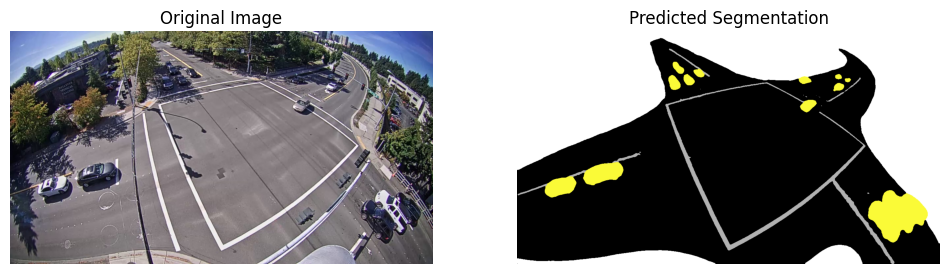

In [24]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# ===========================
# 1. Load Trained Model
# ===========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
best_model = torch.load("/kaggle/working/best_model.pth", map_location=DEVICE)  
best_model.eval()

# ===========================
# 2. Load & Preprocess Test Image
# ===========================
image_path = "/kaggle/input/testinh/frame696.jpg"
image = cv2.imread(image_path)  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Resize image (make dimensions divisible by 32)
new_height = (image.shape[0] // 32) * 32
new_width = (image.shape[1] // 32) * 32
image = cv2.resize(image, (new_width, new_height))

# Define Normalization Values (Adjust if needed)
MEAN = [0.485, 0.456, 0.409]  # Common ImageNet mean
STD = [0.229, 0.224, 0.225]  # Common ImageNet std

# Apply transforms
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=MEAN, std=STD),
])

image_tensor = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

# ===========================
# 3. Perform Inference
# ===========================
with torch.no_grad():
    pred_mask = best_model(image_tensor)  # Model output (batch, classes, H, W)
    pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()  # Get class index per pixel

# ===========================
# 4. Define Custom Color Mapping (Based on Your Provided Colors)
# ===========================
CLASS_COLORS = np.array([
    [0, 0, 0],
        [250, 250, 55],
        [177, 177, 177],
   [255, 255, 255]     # Class 7 - Moving Car
])  

num_classes = CLASS_COLORS.shape[0]  # Get total number of classes

# Map class indices to colors
segmented_mask = CLASS_COLORS[pred_mask]  # Shape: (H, W, 3)

# ===========================
# 5. Display Results
# ===========================
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmented_mask)  # Show color-mapped mask
ax[1].set_title("Predicted Segmentation")
ax[1].axis("off")

plt.show()


In [ ]:
import shutil
shutil.make_archive('/kaggle/working/best_model.pth', 'zip', '/kaggle/working/directory_to_download')


In [ ]:
import requests

url = "https://www.kaggleusercontent.com/best_model.pth.zip"
file_name = "dataset.zip"

response = requests.get(url, stream=True)
with open(file_name, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

print("Download completed!")
